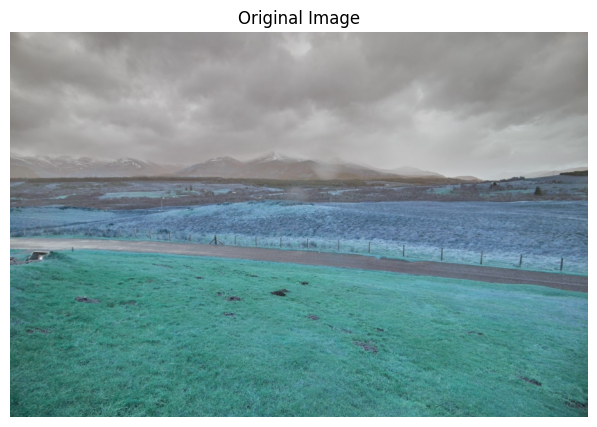

(600, 900, 3)
(300, 450, 3)
(150, 225, 3)


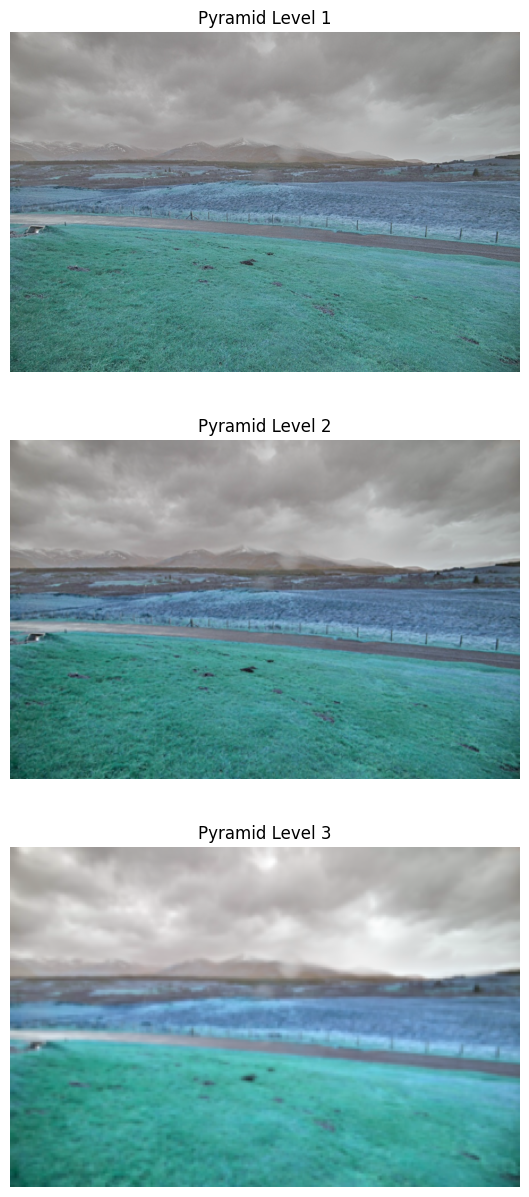

In [9]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F
import cv2

class Lap_Pyramid_Conv(nn.Module):
    def __init__(self, num_high=3, device=torch.device('cpu')):
        super(Lap_Pyramid_Conv, self).__init__()
        self.interpolate_mode = 'bicubic'
        self.num_high = num_high
        self.device = device
        self.kernel = nn.Parameter(torch.zeros(1, 1, 5, 5), requires_grad=True)  # Placeholder for the kernel
        
    def downsample(self, x):
        return x[:, :, ::2, ::2]

    def upsample(self, x, kernel):
        cc = torch.cat([x, torch.zeros(x.shape[0], x.shape[1], x.shape[2], x.shape[3], device=x.device)], dim=3)
        cc = cc.view(x.shape[0], x.shape[1], x.shape[2] * 2, x.shape[3])
        cc = cc.permute(0, 1, 3, 2)
        cc = torch.cat([cc, torch.zeros(x.shape[0], x.shape[1], x.shape[3], x.shape[2] * 2, device=x.device)], dim=3)
        cc = cc.view(x.shape[0], x.shape[1], x.shape[3] * 2, x.shape[2] * 2)
        x_up = cc.permute(0, 1, 3, 2)
        return self.conv_gauss(x_up, kernel)

    def conv_gauss(self, img, kernel):
        device = torch.device('cpu')
        img = img.to(device)
        kernel = kernel.to(device)
        img = torch.nn.functional.pad(img, (2, 2, 2, 2), mode='reflect')
        out = torch.nn.functional.conv2d(img, kernel, groups=img.shape[1])
        return out
    
    def pyramid_decom(self, img, kernel):
        current = img
        pyr = []
        for _ in range(self.num_high):
            filtered = self.conv_gauss(current, kernel)
            down = self.downsample(filtered)
            up = self.upsample(down, kernel)
            # if up.shape[2] != current.shape[2] or up.shape[3] != current.shape[3]:
            #     up = nn.functional.interpolate(up, size=(current.shape[2], current.shape[3]), mode=self.interpolate_mode)
            diff = (current - up)
            pyr.append(diff)
            current = down
        pyr.append(current)
        return pyr

    def pyramid_recons(self, pyr):
        image = pyr[-1]
        for level in reversed(pyr[:-1]):
            image = F.interpolate(image, size=(level.shape[2], level.shape[3]), mode=self.interpolate_mode, align_corners=True) + level
        return image
        
kernel = torch.tensor([[1., 4., 6., 4., 1],
                       [4., 16., 24., 16., 4.],
                       [6., 24., 36., 24., 6.],
                       [4., 16., 24., 16., 4.],
                       [1., 4., 6., 4., 1.]])
kernel /= 256.
kernel = kernel.repeat(3, 1, 1, 1)

# Function to load an image and preprocess it
def load_image(image_path, device):
    img = cv2.imread(r"C:\Users\KRISH DIDWANIA\Desktop\Part2_8[1].JPG")
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    
    img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension
    
    return img, img_tensor

# Visualize the pyramid
def visualize_pyramid(pyramid):
    num_levels = len(pyramid)
    plt.figure(figsize=(15, 5 * num_levels))
    for i, level in enumerate(pyramid):
        level_img = level.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
        level_img = (level_img - level_img.min()) / (level_img.max() - level_img.min()) 
        print(level_img.shape)
        plt.subplot(num_levels, 1, i + 1)
        plt.imshow(level_img)
        plt.title(f'Pyramid Level {i+1}')
        plt.axis('off')
    plt.show()

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    image_path = "/kaggle/input/sice-grad-and-sice-mix/SICEGM/SICE_Reshape/Part1_1.JPG"
    original_img, img_tensor = load_image(image_path, device)

    lap_pyramid = Lap_Pyramid_Conv(num_high=2, device=device).to(device)
    lap_pyramid.kernel.data = kernel.to(device) 

    # Decompose the image into the pyramid
    pyramid = lap_pyramid.pyramid_decom(img_tensor, lap_pyramid.kernel)

    # Visualize the original image and pyramid levels
    plt.figure(figsize=(10, 5))
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    visualize_pyramid(pyramid)


ERROR: Could not find a version that satisfies the requirement python-opencv (from versions: none)
ERROR: No matching distribution found for python-opencv

[notice] A new release of pip is available: 23.2.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip
